In [1]:
import matplotlib.pyplot as plt
import copy

from obspy.clients.fdsn.client import Client
from obspy import UTCDateTime
from obspy.core.event import Catalog
from obspy.core.stream import Stream
from obspy import read_events
from obspy import read_inventory
import cartopy.crs as ccrs


/Users/user/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


# CATALOGUE

In [5]:
client=Client('INGV')

stime=UTCDateTime('2014-01-01T00:00:00')
etime=UTCDateTime('2023-11-18T00:00:00')
lat=40.8478
long=14.0918
rad_events=0.15
min_mag=1

In [6]:
cat=client.get_events(starttime=stime,endtime=etime,includearrivals=False,          
                      latitude=lat,longitude=long,maxradius=rad_events,
                      minmagnitude=min_mag)    

cat               

726 Event(s) in Catalog:
2023-11-11T19:15:55.849000Z | +40.834,  +14.138 | 1.3  Md | manual
2023-11-10T17:51:58.279000Z | +40.827,  +14.142 | 1.3  Md | manual
...
2015-10-07T07:20:34.000000Z | +40.836,  +14.149 | 1.5  Md | manual
2014-09-20T22:09:41.000000Z | +40.800,  +14.130 | 0.6  Md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### create new catalogue with only manual events

In [8]:
cat_manual=Catalog()

#type(cat[0]['origins'][0])
cat[0]['origins'][0].evaluation_mode

for ev in cat:
    if ev['origins'][0].evaluation_mode == 'manual':
        eid=ev.resource_id.id.split('=')[1]                                         #id number
        cat_manual += client.get_events(includearrivals=True,eventid=eid)
        

cat_manual

726 Event(s) in Catalog:
2023-11-11T19:15:55.849000Z | +40.834,  +14.138 | 1.3  Md | manual
2023-11-10T17:51:58.279000Z | +40.827,  +14.142 | 1.3  Md | manual
...
2015-10-07T07:20:34.000000Z | +40.836,  +14.149 | 1.5  Md | manual
2014-09-20T22:09:41.000000Z | +40.800,  +14.130 | 0.6  Md | manual
To see all events call 'print(CatalogObject.__str__(print_all=True))'

### plot events location and mag with cartopy

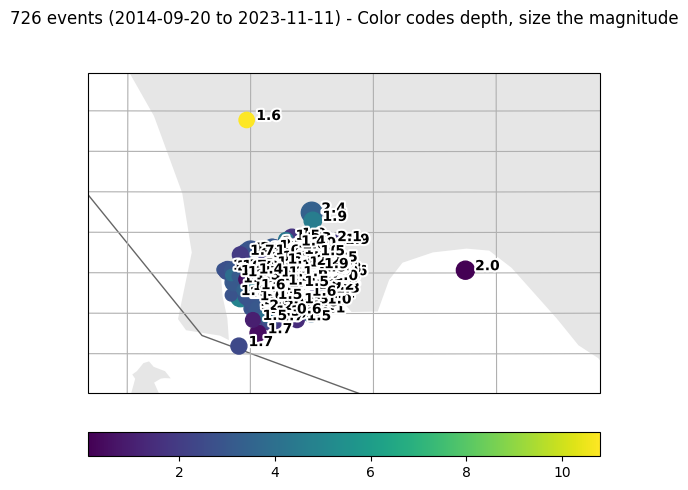

In [11]:
cat_manual.plot(projection='local',resolution='i');

In [38]:
cat_manual[700].picks[1].__dict__

{'resource_id': smi:webservices.ingv.it/fdsnws/event/1/query?pickId=416185421,
 'time': 2018-06-14T22:13:25.110000Z,
 'time_errors': QuantityError({'uncertainty': 0.1, 'lower_uncertainty': None, 'upper_uncertainty': None, 'confidence_level': None}),
 'waveform_id': WaveformStreamID
	  network_code: 'IV'
	  station_code: 'CPOZ'
	  channel_code: 'HHZ'
	 location_code: '',
 'filter_id': None,
 'method_id': smi:webservices.ingv.it/fdsnws/event/1/query?methodID=11,
 'horizontal_slowness': None,
 'horizontal_slowness_errors': None,
 'backazimuth': None,
 'backazimuth_errors': None,
 'slowness_method_id': None,
 'onset': 'questionable',
 'phase_hint': 'P',
 'polarity': 'undecidable',
 'evaluation_mode': 'manual',
 'evaluation_status': None,
 'creation_info': CreationInfo(agency_id='INGV ', author='BULLETIN-INGV', creation_time=UTCDateTime(2019, 2, 4, 18, 36, 19)),
 'comments': []}

### eliminate automatic picking from catalogue

In [35]:
for ev in cat_manual:
    len_pre=len(ev.picks)
    ind_picks=[]
    for ind,pick in enumerate(ev.picks):
        if pick.evaluation_mode == 'automatic':
            ind_picks.append(ind)
    
    for ind in reversed(ind_picks):
        del ev.picks[ind]
    len_post=len(ev.picks)
    if len_pre != len_post:
        print(len_pre,'-------',len_post)

some events have no picks (bad)

save catalogue

In [40]:
cat_manual.write('flegrei_2014_2023/catalogue_flegrei.xml',format='QUAKEML')

# STATIONS

load catalogue from local

In [42]:
catf=read_events('flegrei_2014_2023/catalogue_flegrei.xml')

In [43]:
rad_stations=0.15
inv=client.get_stations(starttime=stime,endtime=etime,
                        latitude=lat,longitude=long,maxradius=rad_stations,
                        level='response')                                   #instrumental response

inv

Inventory created at 2023-11-18T18:33:08.147000Z
	Created by: INGV-ONT WEB SERVICE: fdsnws-station | version: 1.1.57
		    /exist/apps/fdsn-station/fdsnws/station/1/query?starttime=2014-01-0...
	Sending institution: eXistDB (INGV-ONT)
	Contains:
		Networks (2):
			IV, IX
		Stations (19):
			IV.CAAM (Accademia Aeronautica Pozzuoli)
			IV.CAFL (Arco Felice)
			IV.CAWE (Astroni Ovest - Stazione Osservatorio Vesuviano)
			IV.CBAC (Campi Flegrei, Castello di Baia - Stazione Osservatorio Vesu)
			IV.CCAP (Capo Posillipo C. acqisiz. - Stazione Osservatorio Vesuviano)
			IV.CFMN (Monte Nuovo)
			IV.CMIS (Faro di Capo Miseno - Stazione Osservatorio Vesuviano)
			IV.CMSN (Monte S.Angelo)
			IV.CMTS (Campi Flegrei, Via Metastasio CNR-IRC)
			IV.CNIS (Campi Flegrei - Isola di Nisida)
			IV.COLB (Campi Flegrei, Galleria Monte Olibano, Stazione Osservatorio)
			IV.CPIS (Campi Flegrei - Fumarola Pisciarelli)
			IV.CPOZ (Darsena Pozzuoli - Stazione Osservatorio Vesuviano)
			IV.CQUE (Campi Flegrei Qua

In [72]:
for station in inv.networks[0]:
    print(station.code,'source id =',station.source_id)


CAAM source id = None
CAFL source id = None
CAWE source id = None
CBAC source id = None
CCAP source id = None
CFMN source id = None
CMIS source id = None
CMSN source id = None
CMTS source id = None
CNIS source id = None
COLB source id = None
CPIS source id = None
CPOZ source id = None
CQUE source id = None
CSFT source id = None
CSOB source id = None
CSTH source id = None
PTMR source id = None


In [73]:
inv.write('flegrei_2014_2023/inventory_flegrei.xml',format='STATIONXML')                        #save

# WAVEFORMS

In [ ]:
inv_f=read_inventory('flegrei_2014_2023/inventory_flegrei.xml')                                 #read

In [12]:
event_start=catf[0].origins[0].time
event_end=catf[0].origins[0].time +30


wave=Stream()
for  station in inv_f.networks[0].stations:
    try:
        wave += client.get_waveforms(starttime=event_start,endtime=event_end,
                            network='IV',station=station.code,location='*', channel='EH?,HH?',
                            attach_response=True,)
    except:
        print(station.code , 'station not found')
wave.__dict__

CPOZ station not found
CQUE station not found


{'traces': [IV.CAAM..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CAAM..HHN | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CAAM..HHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CBAC..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CBAC..HHN | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CBAC..HHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CCAP..EHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CCAP..EHN | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CCAP..EHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples,
  IV.CFMN..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.

In [13]:
wave.traces[0].stats.sampling_rate

100.0

In [14]:
for tr in wave.traces:
    if tr.stats.sampling_rate == 200.:
        wave.remove(tr)

wave

39 Trace(s) in Stream:

IV.CAAM..HHE | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples
...
(37 other traces)
...
IV.PTMR..HHZ | 2023-10-02T20:08:26.650000Z - 2023-10-02T20:08:56.650000Z | 100.0 Hz, 3001 samples

[Use "print(Stream.__str__(extended=True))" to print all Traces]

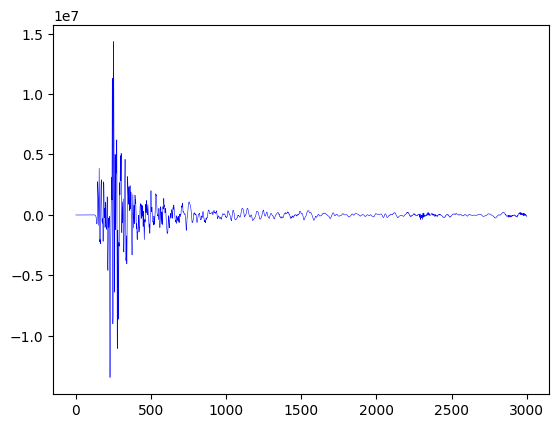

In [15]:
s=wave.traces[1].data
plt.figure('s')
plt.plot(s,'b',linewidth=0.4)
plt.show()

In [16]:
wave.write('wave_f.mseed',format='MSEED')

/Users/user/Library/Python/3.9/lib/python/site-packages/obspy/io/mseed/core.py:821: UserWarning: File will be written with more than one different encodings.
This might have a negative influence on the compatibility with other programs.
  warnings.warn(msg % 'encodings')


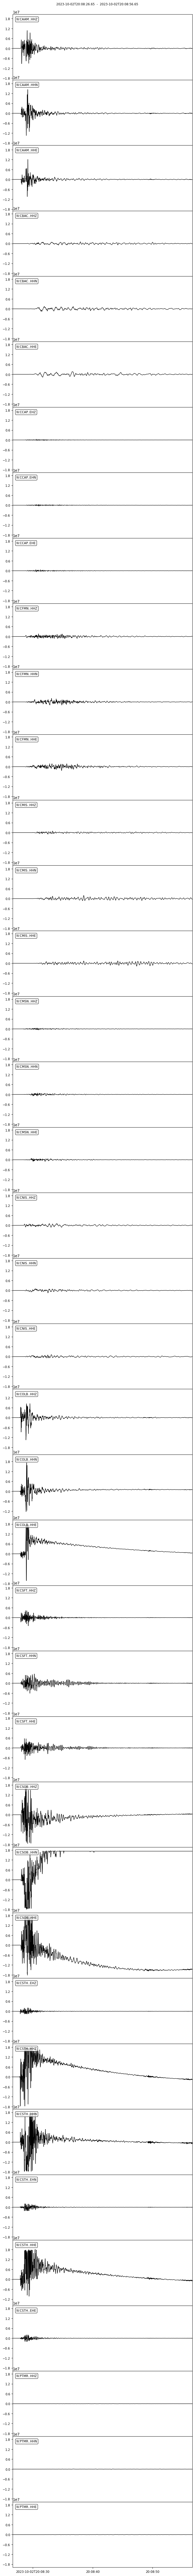

In [17]:
wave.plot();

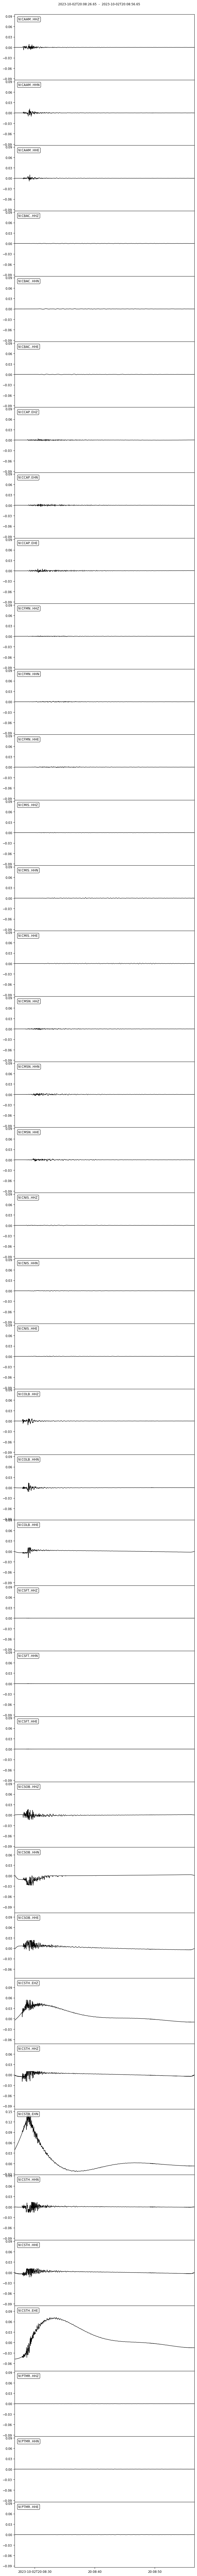

In [18]:
wave_response=copy.deepcopy(wave)
wave_response.remove_response(output="VEL")
wave_response.plot();